## 1. Project Initialization
### 1.1. Library Loading

In [1]:
# Load Necessary Libraries
library(tidyverse)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### 1.2. Data Loading


In [2]:
# Load the Data
anime <- read.csv("anime.csv", stringsAsFactors = FALSE)
anime_synopsis <- read.csv("anime_with_synopsis.csv")
#animelist <- read.csv("animelist.csv")
#rating_complete <- read.csv("rating_complete.csv")
watching_status <- read.csv("watching_status.csv")

### 1.2.0.Large-volume data sampling for GitHub

In [3]:
# Sample a subset of the animelist.csv
#set.seed(123) # Setting a seed for reproducibility
#sample_size_animelist <- 0.01 * nrow(animelist) # Taking 5% of the data as a sample
#animelist_sample <- animelist[sample(nrow(animelist), sample_size_animelist), ]

# Sample a subset of the rating_complete.csv
#set.seed(123) # Setting a seed for reproducibility
#sample_size_rating_complete <- 0.03 * nrow(rating_complete) # Taking 5% of the data as a sample
#rating_complete_sample <- rating_complete[sample(nrow(rating_complete), sample_size_rating_complete), ]

#write.csv(animelist_sample, "animelist_sample.csv", row.names = FALSE)
#write.csv(rating_complete_sample, "rating_complete_sample.csv", row.names = FALSE)


In [4]:
# Load the sample data
animelist <- read.csv("animelist_sample.csv")
rating_complete <- read.csv("rating_complete_sample.csv", stringsAsFactors = FALSE)

## 2. Data Wrangling
### 2.1. Data Cleaning

In [5]:
# Correct data types (converting 'rating' to numeric in rating_complete dataset)
rating_complete$rating <- as.numeric(rating_complete$rating)

# Validate data entries (ensuring 'rating' is between 1 and 10)
rating_complete <- rating_complete %>% filter(rating >= 1 & rating <= 10)

# Handle missing values (removing rows with NA in 'rating' column in rating_complete dataset)
rating_complete <- rating_complete %>% drop_na(rating)

# Cleaning the anime data for the duration
anime_duration <- anime %>%
  select(MAL_ID, Name, Genres, Duration) %>%
  separate_rows(Genres, sep = ",") %>%
  mutate(
    # Convert hours and minutes to total minutes
    Duration = case_when(
      str_detect(Duration, "hr") ~ as.numeric(str_extract(Duration, "\\d+(?= hr)")) * 60 +
                                    as.numeric(ifelse(is.na(str_extract(Duration, "\\d+(?= min)")), 0, str_extract(Duration, "\\d+(?= min)"))),
      TRUE ~ as.numeric(str_extract(Duration, "\\d+"))
    )
  ) %>%
  filter(!is.na(Duration))  # Excluding rows with NA in Duration


### 2.2. Data Transformation

In [6]:
# Create necessary variables (Example: extracting year from 'Aired' in anime dataset)
anime$Start_Year <- as.numeric(str_extract(anime$Aired, "\\b\\d{4}\\b"))

### 2.3. Data Integration

In [7]:
# Merge/Join different datasets (joining anime and anime_with_synopsis on 'MAL_ID')
anime_full <- left_join(anime, anime_synopsis, by = "MAL_ID", suffix = c("_anime", "_synopsis"))

### 2.4. Data Enrichment

In [8]:
# Add additional data or variables (adding a 'Popularity_Rank' variable)
anime_full <- anime_full %>% mutate(Popularity_Rank = dense_rank(desc(Score_anime)))

### 2.5. Data Validation

In [9]:
# Ensure data consistency and accuracy (checking if 'Score' in anime_full is consistent)
summary(anime_full$Score_anime)

   Length     Class      Mode 
    17562 character character 

### 2.6. Data Structuring

In [10]:
# Ensure data is in a suitable structure for analysis (wide to long format)
anime_long <- pivot_longer(anime_full, cols = starts_with("Score."), names_to = "Score_Category", values_to = "Count")

### 2.7. Data Discovery

In [11]:
# Explore data to discover patterns, anomalies, etc.
summary(anime_long)

     MAL_ID       Name_anime        Score_anime        Genres_anime      
 Min.   :    1   Length:175620      Length:175620      Length:175620     
 1st Qu.: 5953   Class :character   Class :character   Class :character  
 Median :22820   Mode  :character   Mode  :character   Mode  :character  
 Mean   :21477                                                           
 3rd Qu.:35625                                                           
 Max.   :48492                                                           
                                                                         
 English.name       Japanese.name          Type             Episodes        
 Length:175620      Length:175620      Length:175620      Length:175620     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                       

### 2.8. Data Consistency Checking

In [12]:
# Ensure data across different sources/tables is consistent (checking number of unique 'MAL_ID')
length(unique(anime$MAL_ID)) == length(unique(anime_synopsis$MAL_ID))

[1] FALSE

In [13]:
# Identifying entries present in one dataset and not the other
missing_in_synopsis <- setdiff(anime$MAL_ID, anime_synopsis$MAL_ID)
missing_in_anime <- setdiff(anime_synopsis$MAL_ID, anime$MAL_ID)

# Investigating the nature of the missing entries
head(anime[anime$MAL_ID %in% missing_in_synopsis, ])
head(anime_synopsis[anime_synopsis$MAL_ID %in% missing_in_anime, ])


,MAL_ID,Name,Score,Genres,English.name,Japanese.name,Type,Episodes,Aired,Premiered,⋯,Score.9,Score.8,Score.7,Score.6,Score.5,Score.4,Score.3,Score.2,Score.1,Start_Year
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
166,188,Gosenzo San'e,6.11,"Comedy, Hentai, Mystery, Supernatural",Masquerade,御先祖賛江,OVA,4,"Sep 25, 1998 to Mar 25, 1999",Unknown,⋯,42.0,89.0,168.0,159.0,132.0,59.0,19.0,20.0,33.0,1998
181,203,Words Worth,6.75,"Adventure, Hentai, Demons, Magic, Fantasy",Unknown,ワーズ・ワース,OVA,5,"Aug 25, 1999 to Nov 25, 2000",Unknown,⋯,291.0,606.0,871.0,577.0,331.0,149.0,69.0,51.0,40.0,1999
189,211,Pure Mail,6.26,Hentai,Unknown,ピュアメール,OVA,2,"Sep 25, 2001 to Dec 21, 2001",Unknown,⋯,71.0,165.0,268.0,310.0,175.0,86.0,43.0,25.0,26.0,2001
191,213,Pia Carrot e Youkoso!!,6.02,"Comedy, Romance, Hentai",Welcome to Pia Carrot,Piaキャロットへようこそ!!,OVA,3,"Oct 24, 1997 to Apr 24, 1998",Unknown,⋯,48.0,114.0,240.0,281.0,196.0,89.0,54.0,18.0,30.0,1997
192,214,Pia Carrot e Youkoso!! 2,6.15,"Comedy, Romance, Hentai",Welcome To Pia Carrot 2,Piaキャロットへようこそ!! 2,OVA,3,"Oct 23, 1998 to Apr 23, 1999",Unknown,⋯,40.0,97.0,169.0,197.0,119.0,62.0,23.0,11.0,28.0,1998
195,217,Shin Angel,6.28,"Comedy, Drama, Hentai, Romance",New Angel,新エンジェル,OVA,5,"Oct 21, 1994 to Nov 22, 1995",Unknown,⋯,47.0,92.0,197.0,176.0,138.0,53.0,20.0,16.0,23.0,1994


MAL_ID,Name,Score,Genres,sypnopsis
<int>,<chr>,<chr>,<chr>,<chr>


## 3. Relational Data Model
### 3.1. Setting Primary and Foreign Keys

For the anime and anime_with_synopsis tables, MAL_ID will be the primary key.

For the animelist and rating_complete tables, we'll have composite keys. In animelist, the combination of user_id and anime_id will be unique. Similarly, in rating_complete, the combination of user_id and anime_id will be unique.

The watching_status table will have status as the primary key.


### 3.2. Setting Relationships

In [14]:
# anime and anime_with_synopsis are related through MAL_ID.(Done)
#anime_full <- left_join(anime, anime_synopsis, by = "MAL_ID", suffix = c("_anime", "_synopsis"))

# animelist and rating_complete are related to anime through anime_id which corresponds to MAL_ID in the anime table.
animelist <- left_join(animelist, anime, by = c("anime_id" = "MAL_ID"), suffix = c("_animelist", "_anime"))

animelist <- left_join(animelist, watching_status, by = c("watching_status" = "status"), suffix = c("_animelist", "_rating"))

# animelist has a relationship with watching_status through watching_status which corresponds to status in the watching_status table.
rating_complete <- left_join(rating_complete, anime, by = c("anime_id" = "MAL_ID"), suffix = c("_rating", "_anime"))


### 3.3. Checking Suitability of the Target Data Model

In [15]:
# Check if there are any missing values in the primary keys
sum(is.na(anime$PK))
sum(is.na(anime_synopsis$PK))
sum(is.na(animelist$PK))
sum(is.na(rating_complete$PK))
sum(is.na(watching_status$PK))


[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

# Q1: Which anime studios produce the most top-rated content?

In [16]:
# First, aggregate the average rating for each anime in the rating_complete dataset
average_ratings <- rating_complete %>%
  group_by(anime_id) %>%
  summarise(avg_rating = mean(rating, na.rm = TRUE))

In [17]:
head(average_ratings)

anime_id,avg_rating
<int>,<dbl>
1,8.776724
5,8.349650
6,8.207658
7,7.511551
8,7.103448
15,8.072000


In [18]:
# Now, merge this aggregated data with anime_data to get studio information
studio_ratings <- inner_join(anime_full, average_ratings, by = c("MAL_ID" = "anime_id"))

In [19]:
head(studio_ratings)

,MAL_ID,Name_anime,Score_anime,Genres_anime,English.name,Japanese.name,Type,Episodes,Aired,Premiered,⋯,Score.3,Score.2,Score.1,Start_Year,Name_synopsis,Score_synopsis,Genres_synopsis,sypnopsis,Popularity_Rank,avg_rating
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,⋯,1357.0,741.0,1580.0,1998,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after.",22,8.776724
2,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,⋯,221.0,109.0,379.0,2001,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized.",58,8.349650
3,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,⋯,664.0,316.0,533.0,1998,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the break

In [20]:
# Next, calculate the average of these average ratings for each studio
studio_avg_ratings <- studio_ratings %>%
  separate_rows(Studios, sep = ",") %>%
  group_by(Studios) %>%
  summarise(studio_avg_rating = mean(avg_rating, na.rm = TRUE)) %>%
  arrange(-studio_avg_rating)

In [21]:
head(studio_avg_ratings)

Studios,studio_avg_rating
<chr>,<dbl>
Coastline Animation Studio,10
Marui Group,10
Tele-Cartoon Japan,10
Square Enix Visual Works,9
Wan Wei Mao Donghua,9
Original Force,9


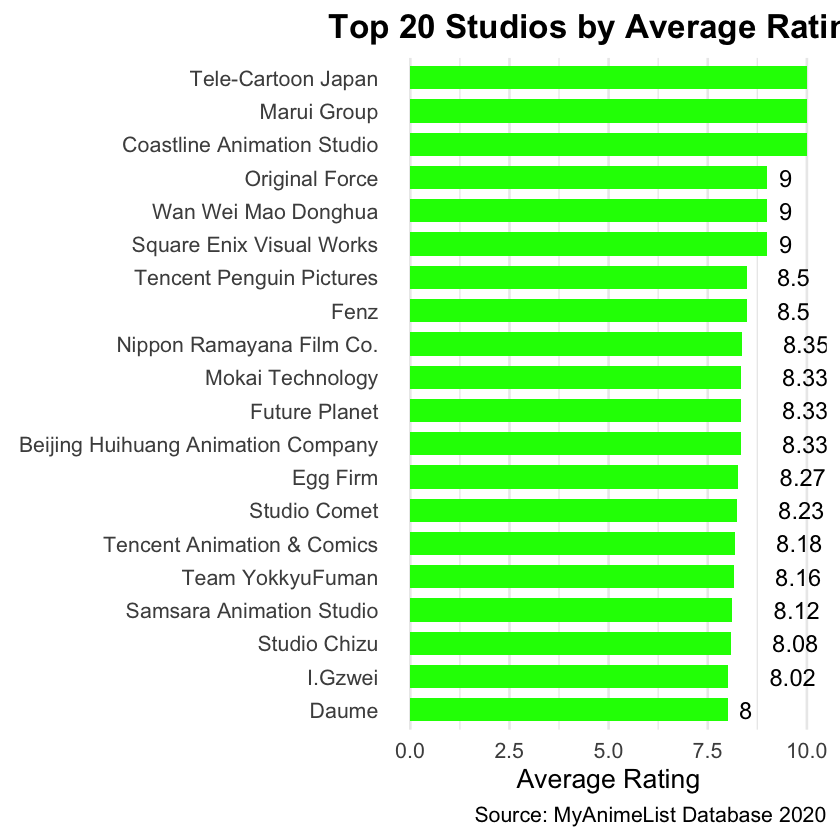

In [22]:
# Visualize the data
ggplot(data = studio_avg_ratings[1:20,], aes(x = reorder(Studios, studio_avg_rating), y = studio_avg_rating)) +
  geom_bar(stat = "identity", fill = "green", width = 0.7) + 
  coord_flip() +
  labs(
    title = "Top 20 Studios by Average Ratings",
    x = "Studio",
    y = "Average Rating",
    caption = "Source: MyAnimeList Database 2020"
  ) +
  theme_minimal(base_size = 16) + 
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20), 
    axis.title.y = element_blank(), 
    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank()
  ) +
  geom_text(aes(label = round(studio_avg_rating, 2)), hjust = -0.9, size = 5, color = "black") # Label for ratings

# Q2: How Do Duration and Popularity Intersect in Anime Ratings?

- What is the duration distribution of the top-rated animes?- 
What are the top 20 rated animes, and how long are they?

In [23]:
# Aggregate the average rating for each anime in the rating_complete dataset
average_ratings <- rating_complete %>%
  group_by(anime_id) %>%
  summarise(avg_rating = mean(rating, na.rm = TRUE))

In [24]:
# Merge the cleaned anime data with average ratings
combined_data <- anime_duration %>%
  left_join(average_ratings, by = c("MAL_ID" = "anime_id")) 

## Analysis: Duration Distribution of Top-Rated Animes

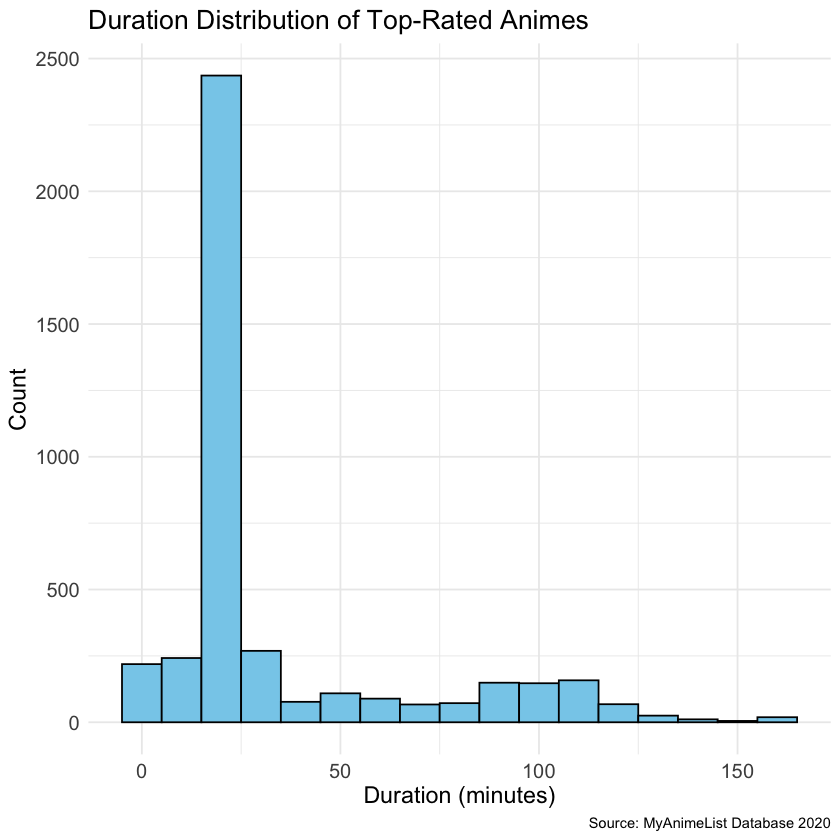

In [25]:
# What is the duration distribution of the top-rated animes? Are top-rated anime series more inclined towards a specific duration range? 
top_rated_animes <- combined_data %>%
  filter(avg_rating >= quantile(combined_data$avg_rating, 0.9, na.rm = TRUE))

ggplot(top_rated_animes, aes(x = Duration)) + 
  geom_histogram(binwidth = 10, fill = "skyblue", color = "black") +
  labs(title = "Duration Distribution of Top-Rated Animes",
       x = "Duration (minutes)",
       y = "Count",
       caption = "Source: MyAnimeList Database 2020") +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.title = element_text(size = 16)
  )


## Deep Dive: Top 20 Rated Animes and Their Duration

In [29]:
# Calculate the average rating for each anime and filter out animes with 1,000 or fewer ratings
average_ratings <- rating_complete %>%
  group_by(anime_id) %>%
  summarise(avg_rating = mean(rating, na.rm = TRUE), num_votes = n()) %>%
  filter(num_votes > 1000)

# Merge the average ratings with the anime data
anime_with_avg_rating <- anime_duration %>%
  left_join(average_ratings, by = c("MAL_ID" = "anime_id"))

head(average_ratings)
head(anime_with_avg_rating)

# Aggregate ratings and duration at the Name level and filter out top 20 rated animes by rating
top_anime <- anime_with_avg_rating %>%
  group_by(Name) %>%
  summarise(avg_rating = mean(avg_rating, na.rm = TRUE),
            avg_duration = mean(Duration, na.rm = TRUE)) %>%
  top_n(20, avg_rating) %>%
  ungroup() %>%
  arrange(-avg_rating)  # Order by rating

top_anime

# Set the size of the output plot
options(repr.plot.width=20, repr.plot.height=10)

anime_id,avg_rating,num_votes
<int>,<dbl>,<int>
1,8.776724,2320
5,8.349650,1001
6,8.207658,1358
20,7.813849,3798
30,8.271403,2815
32,8.422161,1805


MAL_ID,Name,Genres,Duration,avg_rating,num_votes
<int>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,Cowboy Bebop,Action,24,8.776724,2320
1,Cowboy Bebop,Adventure,24,8.776724,2320
1,Cowboy Bebop,Comedy,24,8.776724,2320
1,Cowboy Bebop,Drama,24,8.776724,2320
1,Cowboy Bebop,Sci-Fi,24,8.776724,2320
1,Cowboy Bebop,Space,24,8.776724,2320


Name,avg_rating,avg_duration
<chr>,<dbl>,<dbl>
Fullmetal Alchemist: Brotherhood,9.253768,24
Steins;Gate,9.173691,24
Hunter x Hunter (2011),9.156050,23
Gintama,9.076238,24
Clannad: After Story,9.063070,24
Shingeki no Kyojin Season 3 Part 2,8.981290,23
Koe no Katachi,8.978838,130
Code Geass: Hangyaku no Lelouch R2,8.949973,24
Kimi no Na wa.,8.895806,106


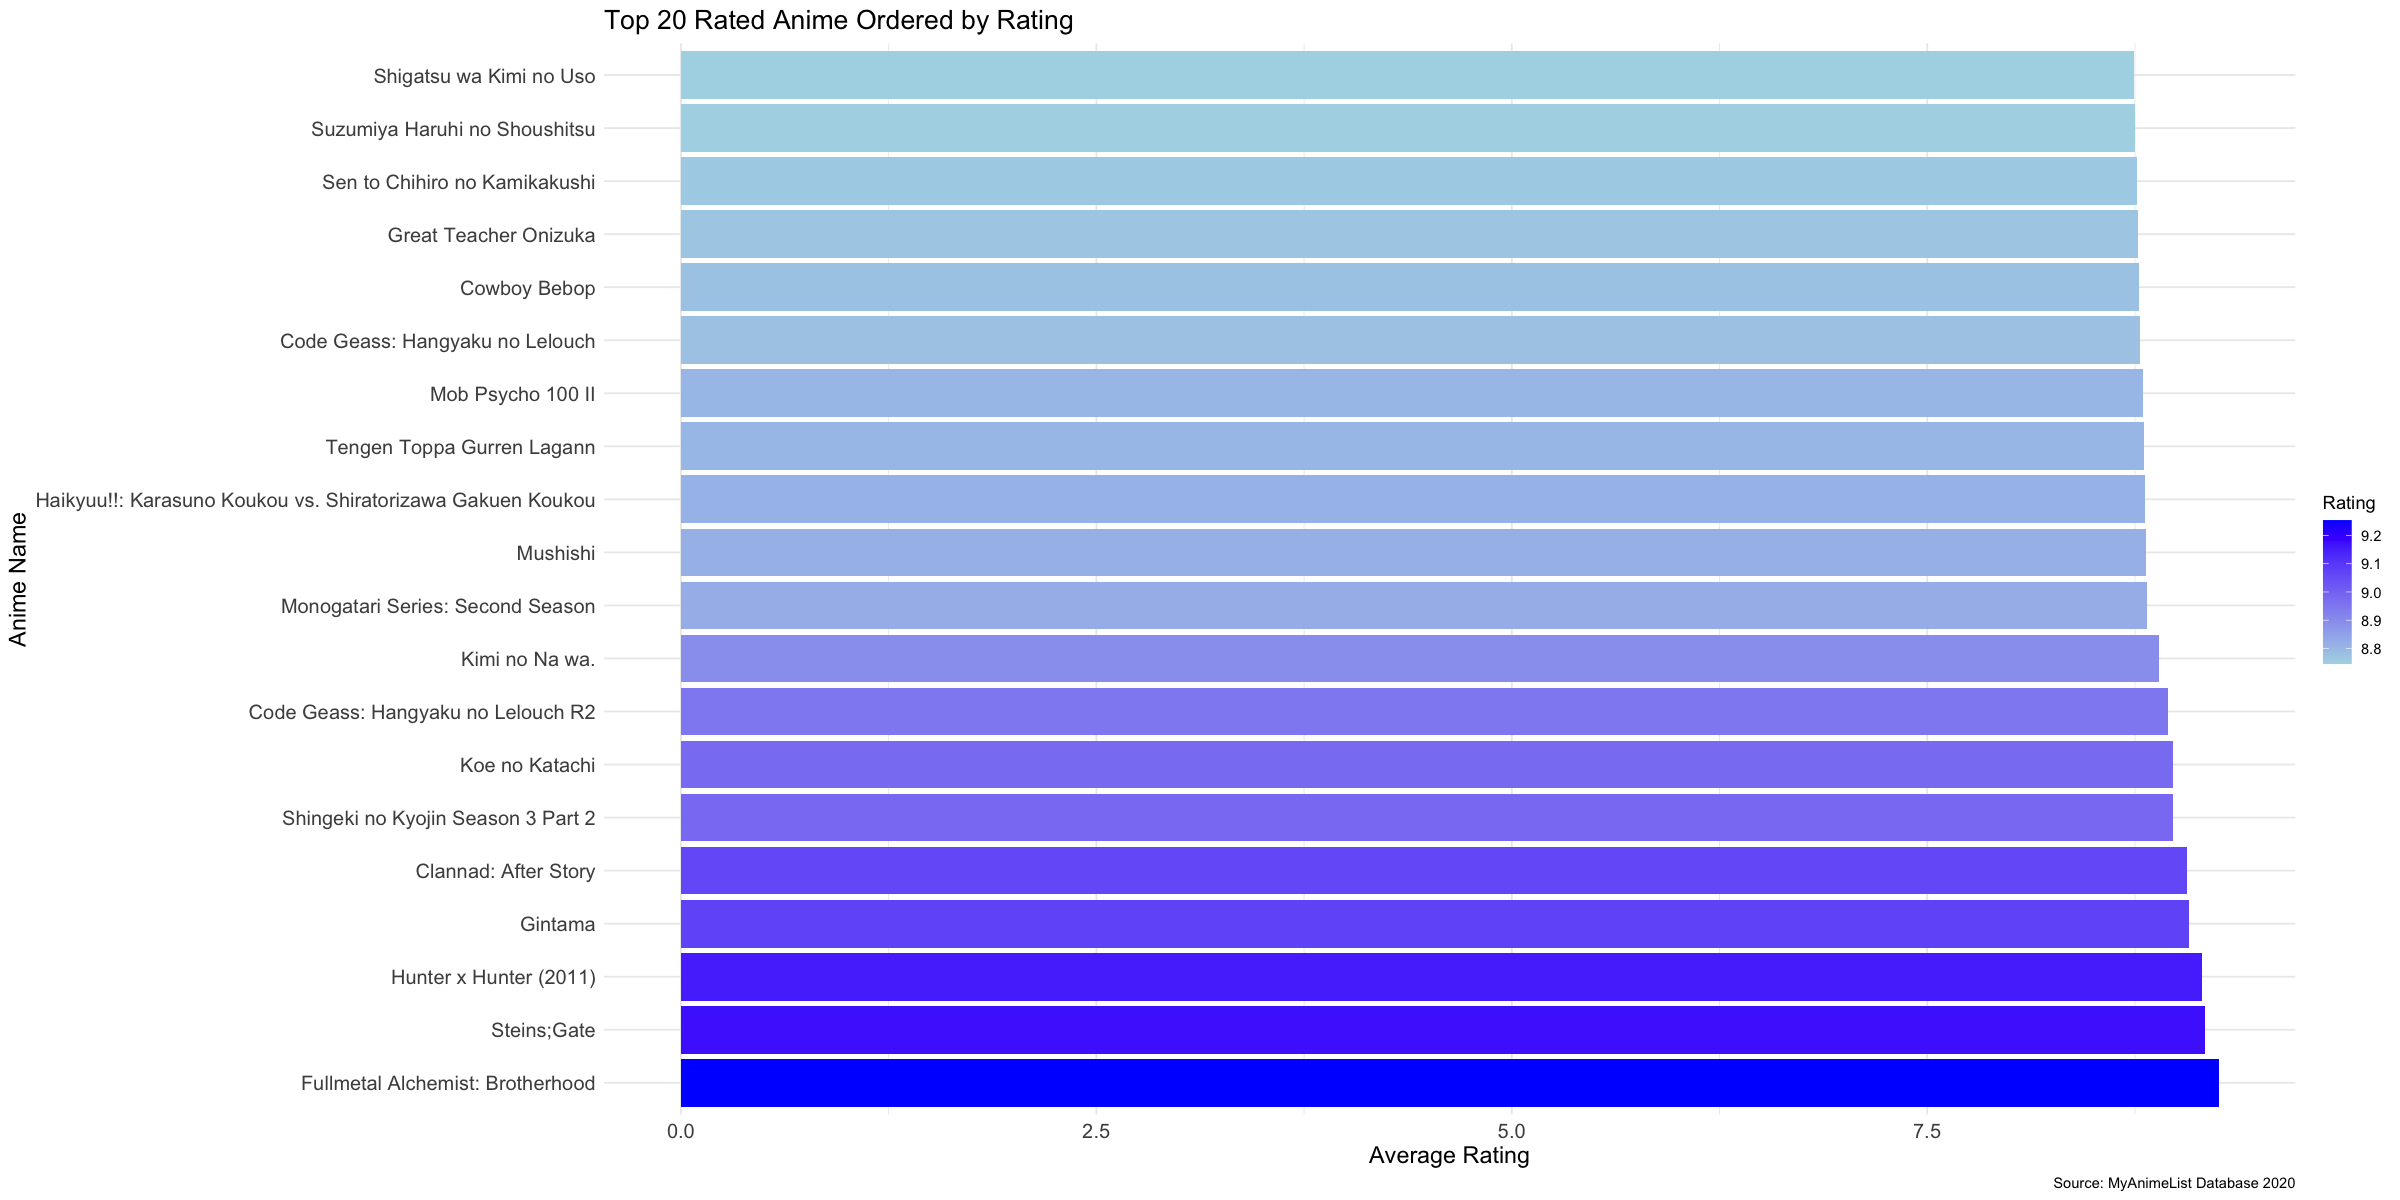

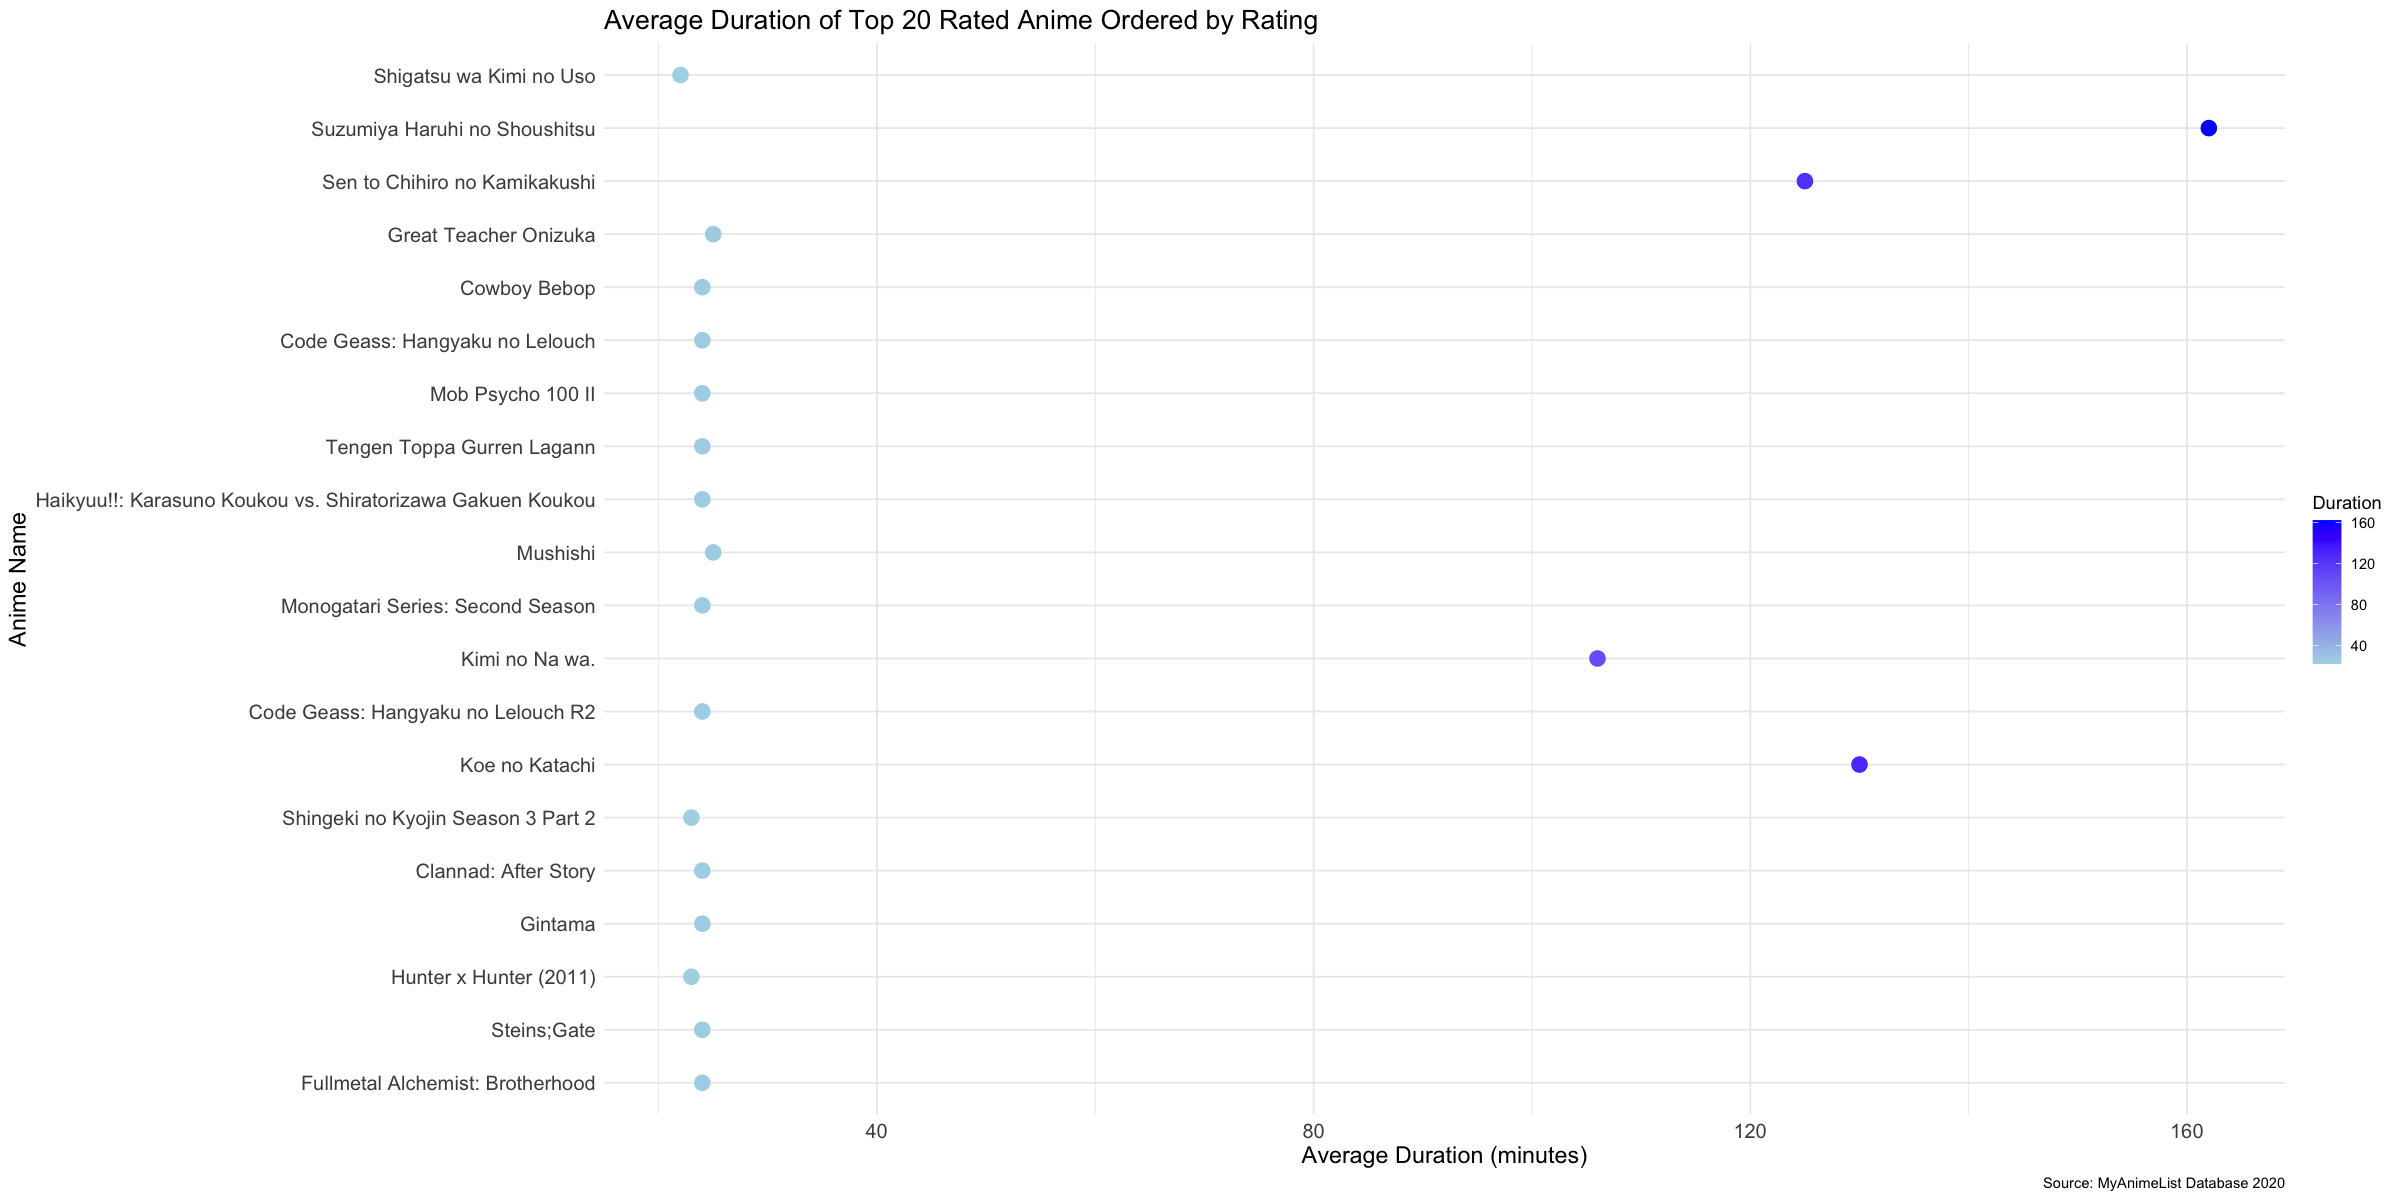

In [30]:
# What are the top 20 rated animes, and how long are they?
# First, a barchart for ratings:

# Plot top 20 rated anime with bars representing their average rating, ordered by rating
ggplot(top_anime, aes(x = reorder(Name, -avg_rating), y = avg_rating, fill = avg_rating)) + 
  geom_bar(stat = "identity") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Rating") +
  coord_flip() +
  labs(title = "Top 20 Rated Anime Ordered by Rating",
       x = "Anime Name",
       y = "Average Rating",
       caption = "Source: MyAnimeList Database 2020") +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.title = element_text(size = 16)
  )


# Then, a dot plot for duration:

ggplot(top_anime, aes(x = reorder(Name, -avg_rating), y = avg_duration)) + 
  geom_point(aes(color = avg_duration), size = 4) +
  scale_color_gradient(low = "lightblue", high = "blue", name = "Duration") +
  coord_flip() +
  labs(title = "Average Duration of Top 20 Rated Anime Ordered by Rating",
       x = "Anime Name",
       y = "Average Duration (minutes)",
       caption = "Source: MyAnimeList Database 2020") +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.title = element_text(size = 16)
  )

